### TARA and NOAA

Download SST data from: https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2.highres/

33 files from 1981 to 2013.

All files from `sst.day.mean.1981.nc` to `sst.day.mean.2013.nc`

In [1]:
import pandas as pd
import os
import xarray as xr
import numpy as np
import pprint
from scipy.spatial import cKDTree
import gc
pp = pprint.PrettyPrinter(indent=4)


In [2]:
output_directory = "/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara"
sst_nc_data_directory = "/Volumes/PortableSSD/Speciale/SST/SST_daily"

os.chdir(sst_nc_data_directory)
print(os.getcwd())


/Volumes/PortableSSD/Speciale/SST/SST_daily


In [3]:
ds = xr.open_dataset("sst.day.mean.1995.nc")
print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 365, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1995-01-01 1995-01-02 ... 1995-12-31
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 2GB ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    history:        Thu Aug 24 13:42:21 2017: ncatted -O -a References,global...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...


### Find water locations

In [160]:

def find_save_water_locations(nc_file, output_file):
    
    # Open the NetCDF file
    sst_data = xr.open_dataset(nc_file)

    # Convert longitude values from 0 to 360 to -180 to 180
    sst_data['lon'] = xr.where(sst_data['lon'] > 180,
                            sst_data['lon'] - 360, sst_data['lon'])

    # Sort longitude values
    sst_data = sst_data.sortby('lon')

    # Extract temperature values
    sst_values = sst_data['sst']

    # Check for NaN values along the time dimension
    nan_mask = np.isnan(sst_values).all(dim='time')

    # Invert the NaN mask to get locations where temperature is generally not NaN (i.e., in water)
    water_mask = ~nan_mask

    # Extract latitude and longitude coordinates where temperature is generally not NaN
    water_lat, water_lon = np.where(water_mask)

    # Create a list of tuples for latitude and longitude combinations
    water_locations = [(sst_data['lat'][i].values, sst_data['lon'][j].values)
                       for i, j in zip(water_lat, water_lon)]

    # Create DataFrame from the list of tuples
    df = pd.DataFrame(water_locations, columns=['lat', 'lon'])

    # Save DataFrame to CSV file
    df.to_csv(output_file, index=False)

    print(f"Locations where temperature is generally not NaN (in water) saved to \n'{
          output_file}'.")

    return df


nc_sst_file = "sst.day.mean.1995.nc"
output_file = 'NOAA_water_locations.csv'

output_file_path = os.path.join(output_directory, output_file)

# Find water locations and save to csv
water_data = find_save_water_locations(nc_sst_file, output_file_path)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/sst.day.mean.1995.nc'

/var/folders/dg/_lhx53rd0n9583q5gqs1fcg80000gn/T/ipykernel_2492/1265713863.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


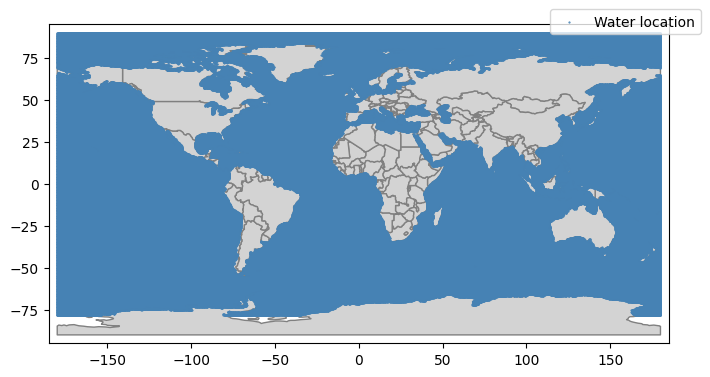

In [125]:
import geopandas as gpd
import numpy as np
import xarray as xr
import pandas as pd
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

water_data = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/NOAA_water_locations.csv")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(8, 5))

# Plot world map
world.plot(ax=ax, color='lightgray', edgecolor='gray')

# Plot points in water
ax.scatter(water_data['lon'], water_data['lat'],
           color='steelblue', label='Water location', s=0.3)

# Set x-axis limits
ax.set_xlim(-185, 185)
ax.set_ylim(-95, 95)

# Set title
ax.set_title('')

# Add legend outside of the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.93, 1.07), ncol=1)


plt.show()


### Match closest locations in NOAA (water) data to Tara data

In [54]:
os.chdir(output_directory)
print(os.getcwd())

water_data = pd.read_csv('NOAA_water_locations.csv')
df = pd.read_csv("TARA_Unique_Dash.csv")


# Convert water_data to numpy array for KD-tree
water_coords = water_data[['lat', 'lon']].values
tree = cKDTree(water_coords)

def find_closest_location(lat, lon):
    # Find the nearest latitude and longitude using KD-tree
    dist, idx = tree.query([lat, lon], k=1)
    nearest_lat, nearest_lon = water_coords[idx]
    return nearest_lat, nearest_lon

# Apply the function to each row in 'df'
df[['lat', 'lon']] = df.apply(lambda row: pd.Series(find_closest_location(row['Latitude'], row['Longitude'])), axis=1)

# Convert 'lat' and 'lon' columns to tuples
df['location'] = list(zip(df['lat'], df['lon']))

# Display the DataFrame with closest matches
print(df)


df.to_csv("Tara_NOAA_locations.csv", index=False)


/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara
            Sample ID  Ammonium  Ammonium std  \
0     TARA_X000000174  0.017782      0.003814   
1     TARA_X000000173  0.017782      0.003814   
2     TARA_X000000172  0.019857      0.004334   
3     TARA_X000000171  0.019621      0.001549   
4     TARA_X000000204  0.019621      0.001549   
...               ...       ...           ...   
4469  TARA_G100017763       NaN           NaN   
4470  TARA_B010001149       NaN           NaN   
4471  TARA_B010001150       NaN           NaN   
4472  TARA_B010001151       NaN           NaN   
4473  TARA_R010000733       NaN           NaN   

                                    BG province    Basis        Campaign  \
0                 North Atlantic Drift Province  SV Tara  TARA_20090905Z   
1                 North Atlantic Drift Province  SV Tara  TARA_20090905Z   
2     North Atlantic Subtropical Gyral Province  SV Tara  TARA_20090905Z   
3     North Atlantic Subtropical Gyral Province 

### Same code - with distance

In [45]:
import os
import pandas as pd
from scipy.spatial import cKDTree


# Read the data
water_data = pd.read_csv('/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/NOAA_water_locations.csv')
df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/TARA_Unique_Dash.csv")


# Convert water_data to numpy array for KD-tree
water_coords = np.radians(water_data[['lat', 'lon']].values)
tree = cKDTree(water_coords)

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the Earth's surface in kilometers using the Haversine formula
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

def find_closest_location(lat, lon):
    # Find the nearest latitude and longitude using KD-tree
    dist, idx = tree.query([np.radians(lat), np.radians(lon)], k=1)
    if isinstance(idx, np.ndarray):
        nearest_coords = water_coords[idx[0]]
    else:
        nearest_coords = water_coords[idx]
    nearest_lat, nearest_lon = nearest_coords
    return np.degrees(nearest_lat), np.degrees(nearest_lon), haversine(lat, lon, np.degrees(nearest_lat), np.degrees(nearest_lon))


# Apply the function to each row in 'df'
df[['nearest_lat', 'nearest_lon', 'distance']] = df.apply(lambda row: pd.Series(find_closest_location(row['Latitude'], row['Longitude'])), axis=1)

# Convert 'lat' and 'lon' columns to tuples
df['location'] = list(zip(df['nearest_lat'], df['nearest_lon']))

# Display the DataFrame with closest matches
print(df)

# Compute statistics
min_distance = df['distance'].min()
max_distance = df['distance'].max()
mean_distance = df['distance'].mean()
std_distance = df['distance'].std()

print("Minimum Distance (km):", min_distance)
print("Maximum Distance (km):", max_distance)
print("Mean Distance (km):", mean_distance)
print("Standard deviation Distance (km):", std_distance)

# Save the DataFrame to CSV
# df.to_csv("Tara_NOAA_locations.csv", index=False)


            Sample ID  Ammonium  Ammonium std  \
0     TARA_X000000174  0.017782      0.003814   
1     TARA_X000000173  0.017782      0.003814   
2     TARA_X000000172  0.019857      0.004334   
3     TARA_X000000171  0.019621      0.001549   
4     TARA_X000000204  0.019621      0.001549   
...               ...       ...           ...   
4469  TARA_G100017763       NaN           NaN   
4470  TARA_B010001149       NaN           NaN   
4471  TARA_B010001150       NaN           NaN   
4472  TARA_B010001151       NaN           NaN   
4473  TARA_R010000733       NaN           NaN   

                                    BG province    Basis        Campaign  \
0                 North Atlantic Drift Province  SV Tara  TARA_20090905Z   
1                 North Atlantic Drift Province  SV Tara  TARA_20090905Z   
2     North Atlantic Subtropical Gyral Province  SV Tara  TARA_20090905Z   
3     North Atlantic Subtropical Gyral Province  SV Tara  TARA_20090913Z   
4     North Atlantic Subtropica

#### Find unique locations (556 in total)

In [55]:
# df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/Tara_NOAA_locations.csv")

# Extract unique combinations of latitudes and longitudes
df_unique_locations = df[['location']].drop_duplicates()

# Convert the 'location' column back to separate 'lat' and 'lon' columns
df_unique_locations[['lat', 'lon']] = pd.DataFrame(
    df_unique_locations['location'].tolist(), index=df_unique_locations.index)


# Drop the 'location' column
# df_unique_locations.drop(columns=['location'], inplace=True).reset_index(drop=True)

df_unique_locations = df_unique_locations.reset_index(drop=True)

# Display the result
print(df_unique_locations.shape)
print(df_unique_locations)

df_unique_locations.to_csv("Tara_NOAA_unique_locations.csv", index=False)


(556, 3)
              location     lat     lon
0     (44.375, -9.875)  44.375  -9.875
1    (39.125, -10.875)  39.125 -10.875
2    (36.625, -10.375)  36.625 -10.375
3     (36.625, -6.625)  36.625  -6.625
4     (36.125, -4.625)  36.125  -4.625
..                 ...     ...     ...
551  (49.875, -22.875)  49.875 -22.875
552  (49.625, -17.375)  49.625 -17.375
553  (48.875, -13.125)  48.875 -13.125
554   (48.625, -9.125)  48.625  -9.125
555   (48.375, -5.125)  48.375  -5.125

[556 rows x 3 columns]


/var/folders/dg/_lhx53rd0n9583q5gqs1fcg80000gn/T/ipykernel_1077/3859884471.py:29: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/dg/_lhx53rd0n9583q5gqs1fcg80000gn/T/ipykernel_1077/3859884471.py:68: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


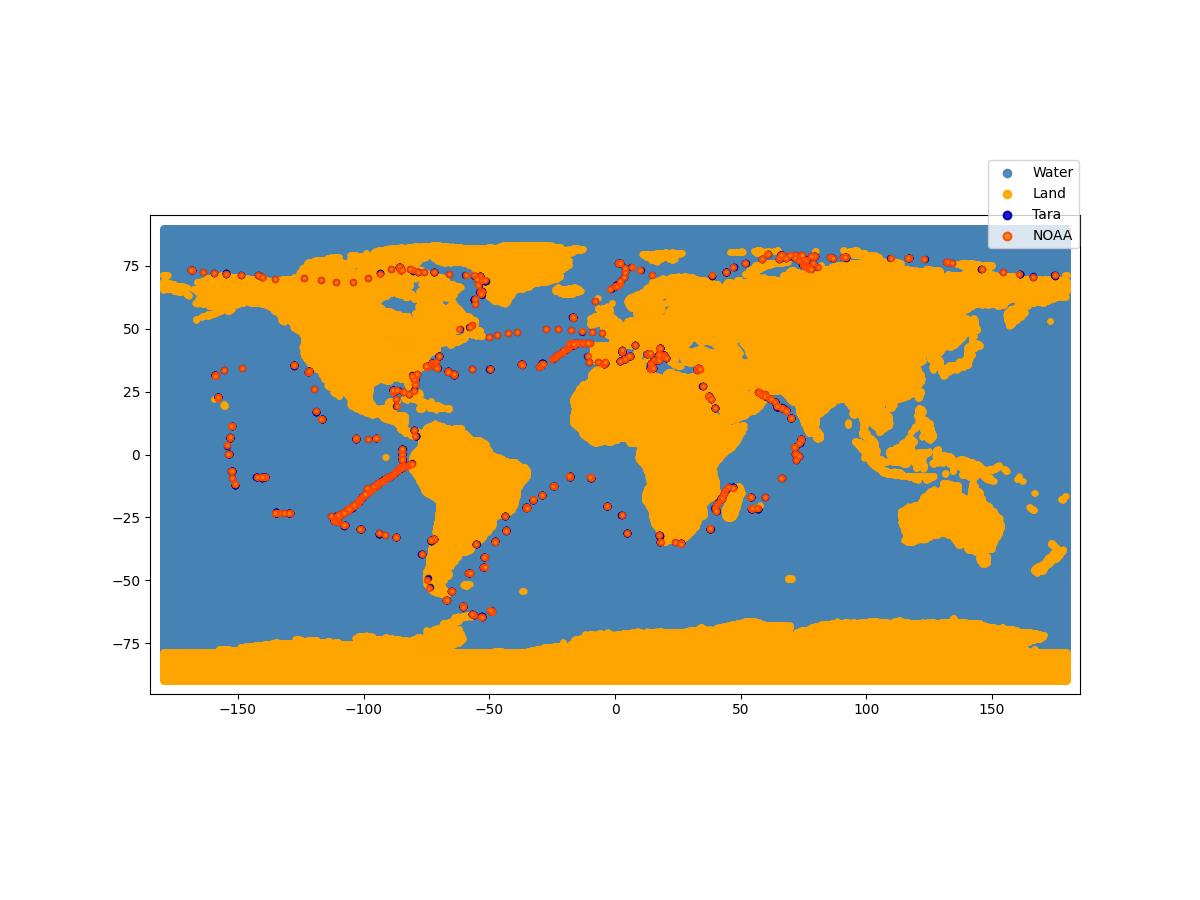

In [6]:
import geopandas as gpd
import numpy as np
import xarray as xr
import pandas as pd
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib widget
# %matplotlib inline

df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/TARA_Unique_Dash.csv")

# # Convert 'lat' and 'lon' columns to tuples
# df['Location'] = list(zip(df['Latitude'], df['Longitude']))

# print(df.head())

tara_locations = df.drop_duplicates(subset=['Latitude', 'Longitude']).reset_index(drop=True)
tara_locations['Location'] = list(zip(tara_locations['Latitude'], tara_locations['Longitude']))

water_data = pd.read_csv('/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/NOAA_water_locations.csv')
land_data = pd.read_csv('/Volumes/PortableSSD/Speciale/SST/SST_daily/land_locations.csv')

tara_sst_locations = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/Tara_NOAA_unique_locations.csv")


# tara_sst_locations = df_unique_locations.copy()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(12, 9))

# Plot world map
world.plot(ax=ax, color='lightgray', edgecolor='gray')

# Plot points in water


ax.scatter(water_data['lon'], water_data['lat'],
           color='steelblue', label='Water', s=10,
           marker='o', linewidths=1.5, alpha=0.9)

ax.scatter(land_data['Longitude'], land_data['Latitude'],
           color='orange', label='Land', s=10,
           marker='o', linewidths=1.5, alpha=0.9)

ax.scatter(tara_locations['Longitude'], tara_locations['Latitude'],
           color='blue', edgecolor='darkblue', label='Tara', s=14,
           marker='o', linewidths=1.6, alpha=0.9)

ax.scatter(tara_sst_locations['lon'], tara_sst_locations['lat'],
           color='darkorange', edgecolor='orangered', label='NOAA', s=14,
           marker='o', linewidths=1.6, alpha=0.9)



# Set x-axis limits
ax.set_xlim(-185, 185)
ax.set_ylim(-95, 95)

# Set title
ax.set_title(' ', fontsize=32)

# Add legend outside of the plot
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.95, 1.13), ncol=1)

# Increase marker size in legend
for handle in legend.legendHandles:
    handle.set_sizes([30])

plt.show()


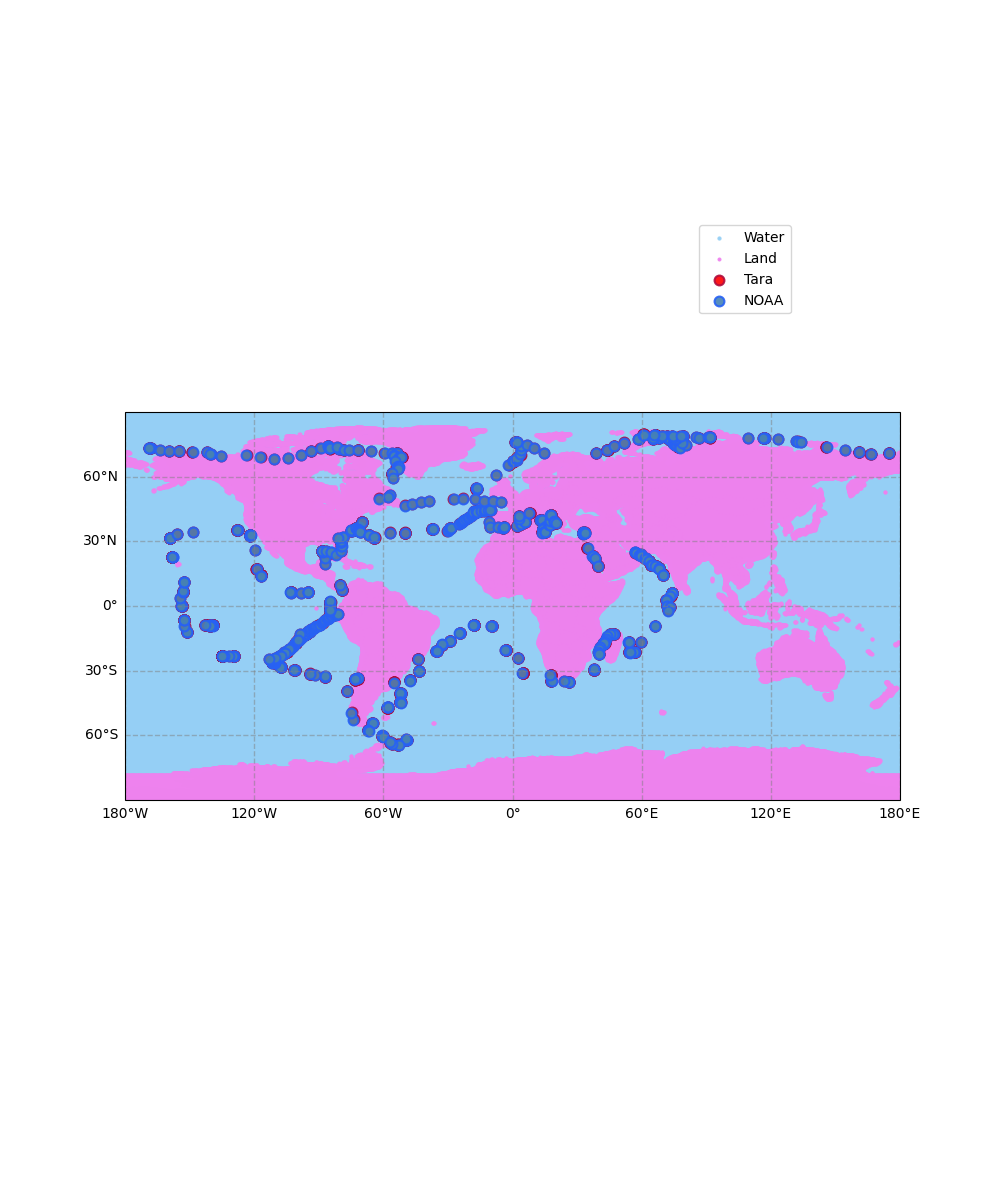

In [43]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
# from cartopy.mpl.scale_bar import ScaleBar
from matplotlib_scalebar.scalebar import ScaleBar

# Constants for the world map grid
grid_resolution = 0.25  # degrees
grid_rows = 720  # grid cells
grid_cols = 1440  # grid cells

# Calculate the distance represented by each degree of latitude and longitude at the center of the map
latitude_distance = 111.32  # Kilometers per degree at the equator
longitude_distance = 111.32  # Kilometers per degree at the equator (approximation)

# Calculate the length of the scale bar in kilometers
scale_bar_length = grid_resolution * grid_cols * longitude_distance


# Create a Cartopy projection
projection = ccrs.PlateCarree()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 12), subplot_kw={'projection': projection})

# Add Natural Earth features (higher resolution)
ax.add_feature(cfeature.LAND, facecolor='gainsboro', edgecolor='silver', linewidth=1)
ax.add_feature(cfeature.COASTLINE, edgecolor='silver', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot points in water
# ax.scatter(tara_locations['Longitude'], tara_locations['Latitude'],
#            transform=ccrs.PlateCarree(), color='steelblue', edgecolor='darkblue', label='Tara', s=14,
#            marker='o', linewidths=1.6, alpha=0.9, zorder=2)

# ax.scatter(tara_sst_locations['lon'], tara_sst_locations['lat'],
#            transform=ccrs.PlateCarree(), color='orange', edgecolor='darkorange', label='NOAA', s=14,
#            marker='x', linewidths=1.6, alpha=0.9, zorder=2)

ax.scatter(water_data['lon'], water_data['lat'],
           color='#95cff5', label='Water', s=10,
           marker='.', linewidths=1.5, alpha=0.9, zorder=2)

ax.scatter(land_data['Longitude'], land_data['Latitude'],
           color='violet', label='Land', s=8,
           marker='.', linewidths=1.5, alpha=0.9, zorder=2)

ax.scatter(tara_locations['Longitude'], tara_locations['Latitude'],
           color='red', edgecolor='#b00c3d', label='Tara', s=50,
           marker='o', linewidths=1.5, alpha=0.9, zorder=2)

ax.scatter(tara_sst_locations['lon'], tara_sst_locations['lat'],
           color='#4682b4', edgecolor='#2761f5', label='NOAA', s=50,
           marker='o', linewidths=1.5, alpha=0.9, zorder=2)

# Add gridlines with coordinates
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER



# Set x-axis limits
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

# Set title
ax.set_title(' ', fontsize=32)

# Add legend
ax.legend(loc='upper center', bbox_to_anchor=(0.8, 1.5), ncol=1)

plt.show()


#### Change directory to sst_nc_data_directory

In [14]:

os.chdir(sst_nc_data_directory)
print(os.getcwd())


def get_nc_files(folder_path):
    nc_files = []
    for file in os.listdir(folder_path):
        if file.endswith(".nc") and file.startswith("sst"):
            nc_files.append(file)

    return sorted(nc_files)


nc_files_list = get_nc_files(sst_nc_data_directory)
# print(nc_files_list)


output_names = {}

for nc_path in nc_files_list:
    # print(nc_path)
    year = nc_path.split(".")[-2]
    output_names[nc_path]=f"SST-{year}.csv"

print(output_names)


/Volumes/PortableSSD/Speciale/SST/SST_daily
{'sst.day.mean.1981.nc': 'SST-1981.csv', 'sst.day.mean.1982.nc': 'SST-1982.csv', 'sst.day.mean.1983.nc': 'SST-1983.csv', 'sst.day.mean.1984.nc': 'SST-1984.csv', 'sst.day.mean.1985.nc': 'SST-1985.csv', 'sst.day.mean.1986.nc': 'SST-1986.csv', 'sst.day.mean.1987.nc': 'SST-1987.csv', 'sst.day.mean.1988.nc': 'SST-1988.csv', 'sst.day.mean.1989.nc': 'SST-1989.csv', 'sst.day.mean.1990.nc': 'SST-1990.csv', 'sst.day.mean.1991.nc': 'SST-1991.csv', 'sst.day.mean.1992.nc': 'SST-1992.csv', 'sst.day.mean.1993.nc': 'SST-1993.csv', 'sst.day.mean.1994.nc': 'SST-1994.csv', 'sst.day.mean.1995.nc': 'SST-1995.csv', 'sst.day.mean.1996.nc': 'SST-1996.csv', 'sst.day.mean.1997.nc': 'SST-1997.csv', 'sst.day.mean.1998.nc': 'SST-1998.csv', 'sst.day.mean.1999.nc': 'SST-1999.csv', 'sst.day.mean.2000.nc': 'SST-2000.csv', 'sst.day.mean.2001.nc': 'SST-2001.csv', 'sst.day.mean.2002.nc': 'SST-2002.csv', 'sst.day.mean.2003.nc': 'SST-2003.csv', 'sst.day.mean.2004.nc': 'SST-2004.c

### Merge and subset SST data

In [15]:
path = "/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/Tara_NOAA_unique_locations.csv"
df_unique_locations = pd.read_csv(path)
# df_unique_locations = pd.read_csv("Tara_NOAA_unique_locations.csv")


def merge_subset_sst_data(nc_file, locations_df, csv_output):
    """
    Merge and subset SST data from multiple files based on the given locations DataFrame.

    Parameters:
        file_paths (list): List of file paths containing SST data.
        locations_df (DataFrame): DataFrame containing 'lat' and 'lon' columns.

    Returns:
        merged_data (DataFrame): Merged and subsetted SST data in DataFrame format.
    """

    # Extract latitude and longitude values
    lats = locations_df['lat'].values
    lons = locations_df['lon'].values

    print(nc_file)
    # Load external SST data

    with xr.open_dataset(nc_file) as dataset:
        
        dataset.load()

        # Sort longitude values
        dataset = dataset.sortby('lon')

        # Convert longitude values from 0 to 360 to -180 to 180
        dataset['lon'] = xr.where(dataset['lon'] > 180,
                                dataset['lon'] - 360, dataset['lon'])

        # Sort longitude values
        dataset = dataset.sortby('lon')

        rows = []

        for lon, lat in zip(lons, lats):

            # Subset the data for the specified locations
            subset_data = dataset.sel(lon=lon, lat=lat, method='nearest')

            # Subset only the 'sst' variable
            sst_data = subset_data['sst']

            for row in sst_data:

                date = row['time'].values
                temp = row.values

                rows.append({'lon': lon, 'lat': lat,
                            'date': date, 'temp': temp})

        # Create DataFrame for the current file
        df = pd.DataFrame(rows)

        dataset.close()

    # Save to csv
    df.to_csv(csv_output, index=False)
    
    print(f"{nc_file} saved to {csv_output}")

    del rows
    del df
    del dataset
           
    return 


for file_name, output_name in output_names.items():
    merge_subset_sst_data(file_name, df_unique_locations, output_name)
    gc.collect()


sst.day.mean.1981.nc
sst.day.mean.1981.nc saved to SST-1981.csv
sst.day.mean.1982.nc
sst.day.mean.1982.nc saved to SST-1982.csv
sst.day.mean.1983.nc
sst.day.mean.1983.nc saved to SST-1983.csv
sst.day.mean.1984.nc
sst.day.mean.1984.nc saved to SST-1984.csv
sst.day.mean.1985.nc
sst.day.mean.1985.nc saved to SST-1985.csv
sst.day.mean.1986.nc
sst.day.mean.1986.nc saved to SST-1986.csv
sst.day.mean.1987.nc
sst.day.mean.1987.nc saved to SST-1987.csv
sst.day.mean.1988.nc
sst.day.mean.1988.nc saved to SST-1988.csv
sst.day.mean.1989.nc
sst.day.mean.1989.nc saved to SST-1989.csv
sst.day.mean.1990.nc
sst.day.mean.1990.nc saved to SST-1990.csv
sst.day.mean.1991.nc
sst.day.mean.1991.nc saved to SST-1991.csv
sst.day.mean.1992.nc
sst.day.mean.1992.nc saved to SST-1992.csv
sst.day.mean.1993.nc
sst.day.mean.1993.nc saved to SST-1993.csv
sst.day.mean.1994.nc
sst.day.mean.1994.nc saved to SST-1994.csv
sst.day.mean.1995.nc
sst.day.mean.1995.nc saved to SST-1995.csv
sst.day.mean.1996.nc
sst.day.mean.1996.n

### Merge SST files to one file

In [17]:
# sst_csv_folder = "/Users/annaolsen/Desktop/Speciale/DS_thesis/data/SST/merged"
sst_csv_folder = "/Volumes/PortableSSD/Speciale/SST/SST_daily"

os.chdir(sst_csv_folder)
print(os.getcwd())


def get_csv_files(folder_path):
    csv_files = []
    for file in os.listdir(folder_path):
        if file.startswith("SST") and file.endswith(".csv"):
            csv_files.append(file)

    return sorted(csv_files)


csv_files_list = get_csv_files(sst_csv_folder)
print(csv_files_list)


dataframes = []

for file in csv_files_list:
    dataframes.append(pd.read_csv(file))

merged_df = pd.concat(dataframes, ignore_index=True)

print(merged_df.shape)

print(merged_df.head())

# Write the merged DataFrame to a new CSV file
merged_df.to_csv('NOAA_SST_1981-2013.csv', index=False)

/Volumes/PortableSSD/Speciale/SST/SST_daily
['SST-1981.csv', 'SST-1982.csv', 'SST-1983.csv', 'SST-1984.csv', 'SST-1985.csv', 'SST-1986.csv', 'SST-1987.csv', 'SST-1988.csv', 'SST-1989.csv', 'SST-1990.csv', 'SST-1991.csv', 'SST-1992.csv', 'SST-1993.csv', 'SST-1994.csv', 'SST-1995.csv', 'SST-1996.csv', 'SST-1997.csv', 'SST-1998.csv', 'SST-1999.csv', 'SST-2000.csv', 'SST-2001.csv', 'SST-2002.csv', 'SST-2003.csv', 'SST-2004.csv', 'SST-2005.csv', 'SST-2006.csv', 'SST-2007.csv', 'SST-2008.csv', 'SST-2009.csv', 'SST-2010.csv', 'SST-2011.csv', 'SST-2012.csv', 'SST-2013.csv']
(6566360, 4)
     lon     lat        date       temp
0 -9.875  44.375  1981-09-01  19.220000
1 -9.875  44.375  1981-09-02  19.449999
2 -9.875  44.375  1981-09-03  19.590000
3 -9.875  44.375  1981-09-04  19.699999
4 -9.875  44.375  1981-09-05  19.600000


#### Land locations

In [ ]:

# def find_land_locations_and_save(ds, output_file):
#     # Open the NetCDF file
#     # ds = xr.open_dataset(nc_file_path)

#     # Extract temperature values
#     sst_values = ds['sst']

#     # Check for NaN values along the time dimension
#     nan_mask = np.isnan(sst_values).all(dim='time')

#     # Extract latitude and longitude coordinates where temperature is always NaN
#     nan_lat, nan_lon = np.where(nan_mask)

#     # Create a list of tuples for latitude and longitude combinations
#     land_locations = [(ds['lat'][i].values, ds['lon'][j].values)
#                       for i, j in zip(nan_lat, nan_lon)]

#     # Create DataFrame from the list of tuples
#     df = pd.DataFrame(land_locations, columns=['Latitude', 'Longitude'])

#     # Save DataFrame to CSV file
#     df.to_csv(output_file, index=False)

#     print(f"Locations where sst is always NaN saved to '{output_file}'.")

#     return df


# # output_file = 'land_locations.csv'
# # find_land_locations_and_save(sst_data, output_file)